In [20]:
import pandas as pd

# Load dataset
df = pd.read_excel('dataset/2022/ACMV-CHL-5-(01012022_1200AM-01072022_1200AM).xlsx')

# Check for duplicates
duplicates = df[df.duplicated(subset=['Timestamp', 'Datasource'], keep=False)]
if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate rows. Resolving by aggregation.")
    # Resolve duplicates by taking the mean of duplicate entries
    df = df.groupby(['Timestamp', 'Datasource'], as_index=False).mean()

# Pivot the table to wide format
try:
    df_wide = df.pivot(index='Timestamp', columns='Datasource', values='Value')
    df_wide.reset_index(inplace=True)  # Reset index for easier handling
    print("Pivot successful!")
except ValueError as e:
    print(f"Error during pivoting: {e}")

# Forward fill missing values
df_wide.ffill(inplace=True)

# Backward fill missing values (if needed)
df_wide.bfill(inplace=True)

# Display the first few rows of the prepared data
print(df_wide.head())


Found 177 duplicate rows. Resolving by aggregation.
Pivot successful!
Datasource           Timestamp  BUILDING A\CHL\5:=DAILY STARTS  \
0          2022-01-05 22:20:00                             1.0   
1          2022-01-05 22:25:00                             1.0   
2          2022-01-05 22:30:00                             1.0   
3          2022-01-05 22:35:00                             1.0   
4          2022-01-05 22:40:00                             1.0   

Datasource  BUILDING A\CHL\5:=DUTY CYCLE  BUILDING A\CHL\5:CDW FLOW  \
0                                    0.0                  -0.019607   
1                                    0.0                  -0.019607   
2                                    0.0                  -0.020650   
3                                    0.0                  -0.018888   
4                                    0.0                  -0.019978   

Datasource  BUILDING A\CHL\5:CDW RT  BUILDING A\CHL\5:CDW RWT  \
0                               0.0      

In [21]:
# Calculate basic statistics for each datasource
stats = df_wide.describe().T  # Transpose to see stats per datasource
print(stats)


                                  count                           mean  \
Datasource                                                               
Timestamp                         50707  2022-04-03 23:09:55.663320832   
BUILDING A\CHL\5:=DAILY STARTS  50707.0                      71.528606   
BUILDING A\CHL\5:=DUTY CYCLE    50707.0                       0.157269   
BUILDING A\CHL\5:CDW FLOW       50707.0                      10.406736   
BUILDING A\CHL\5:CDW RT         50707.0                      45.702181   
BUILDING A\CHL\5:CDW RWT        50707.0                      19.728999   
BUILDING A\CHL\5:CDW SWT        50707.0                      18.846923   
BUILDING A\CHL\5:CHW FLOW       50707.0                       6.038716   
BUILDING A\CHL\5:CHW RT         50707.0                      41.083678   
BUILDING A\CHL\5:CHW RWT        50707.0                      10.826312   
BUILDING A\CHL\5:CHW SWT        50707.0                       9.897936   
BUILDING A\CHL\5:CMD            50707.

In [22]:
# Define thresholds based on 3 standard deviations from the mean
thresholds = {}
for col in df_wide.columns[1:]:  # Skip the 'Timestamp' column
    mean = stats.loc[col, 'mean']
    std = stats.loc[col, 'std']
    upper_threshold = mean + 3 * std  # Upper bound for anomalies
    lower_threshold = mean - 3 * std  # Lower bound for anomalies
    thresholds[col] = (lower_threshold, upper_threshold)

print("Thresholds for each datasource:")
print(thresholds)


Thresholds for each datasource:
{'BUILDING A\\CHL\\5:=DAILY STARTS': (-96.11156692073752, 239.16877795668915), 'BUILDING A\\CHL\\5:=DUTY CYCLE': (-0.25689930531151983, 0.5714380917276987), 'BUILDING A\\CHL\\5:CDW FLOW': (-63.16870174984416, 83.982172789105), 'BUILDING A\\CHL\\5:CDW RT': (-294.4158647027123, 385.82022658918453), 'BUILDING A\\CHL\\5:CDW RWT': (-18.27703753970277, 57.73503488010937), 'BUILDING A\\CHL\\5:CDW SWT': (-17.151598618708114, 54.845445519136), 'BUILDING A\\CHL\\5:CHW FLOW': (-37.529518596494746, 49.60694992031613), 'BUILDING A\\CHL\\5:CHW RT': (-265.1032646070722, 347.2706202245794), 'BUILDING A\\CHL\\5:CHW RWT': (-10.065235348467088, 31.717859299400853), 'BUILDING A\\CHL\\5:CHW SWT': (-10.099664847380506, 29.89553677236125), 'BUILDING A\\CHL\\5:CMD': (-0.9222158103041525, 1.2232393376277961), 'BUILDING A\\CHL\\5:EFF': (-0.5764758851680486, 0.7249804428148033), 'BUILDING A\\CHL\\5:KW': (-124.48653241858322, 163.70402349476592), 'BUILDING A\\CHL\\5:STS': (-0.92236

In [23]:
# Add a label column for anomalies
df_wide['anomaly_labels'] = 0  # Default to normal

# Flag anomalies for each datasource
for col in df_wide.columns[1:-1]:  # Skip 'Timestamp' and 'anomaly_labels'
    lower, upper = thresholds[col]
    df_wide.loc[(df_wide[col] < lower) | (df_wide[col] > upper), 'anomaly_labels'] = 1

# Check the distribution of anomaly labels
print("Anomaly label distribution:")
print(df_wide['anomaly_labels'].value_counts())


Anomaly label distribution:
anomaly_labels
0    48990
1     1717
Name: count, dtype: int64


In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Normalize data (excluding labels)
scaler = MinMaxScaler()
data = scaler.fit_transform(df_wide.iloc[:, 1:])  # Skip 'Timestamp'

# Function to create sequences and labels
def create_sequences_with_labels(data, labels, time_steps=10):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps):
        # Extract a sequence
        seq = data[i:i + time_steps]
        # Use the label of the last time step as the sequence label
        label = labels[i + time_steps - 1]
        sequences.append(seq)
        sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

# Create labeled sequences
time_steps = 10
labels = df_wide['anomaly_labels'].values  # Replace with your labels column
X, y = create_sequences_with_labels(data, labels, time_steps)

# Split into training and testing sets
split = int(0.8 * len(X))  # 80% training, 20% testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (40557, 10, 16), (40557,)
Testing data shape: (10140, 10, 16), (10140,)


In [25]:
from tensorflow.keras.layers import Input

# Define LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,  # Adjust based on your dataset size
    batch_size=32,
    validation_split=0.2,  # 20% of training data for validation
    shuffle=True
)


Epoch 1/20
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9779 - loss: 0.1091 - val_accuracy: 1.0000 - val_loss: 0.0105
Epoch 2/20
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9994 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 3/20
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 8.5679e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 4/20
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 3.8531e-04 - val_accuracy: 1.0000 - val_loss: 5.2961e-04
Epoch 5/20
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 2.1230e-04 - val_accuracy: 1.0000 - val_loss: 2.9354e-04
Epoch 6/20
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 1.0000 - loss: 1.1941e-04 - val_accuracy: 1.0000 - val_loss: 1.6964e-04
Epoch 7/20
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 6.4381e-05 - val_accuracy: 1.0000 - val_loss: 1.0041e-04
Epoch 8/20
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step 

In [27]:
# Evaluate on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Import metrics for evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 6.4903e-08
Test Loss: 8.44944096911604e-08, Test Accuracy: 1.0
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9826
           1       1.00      1.00      1.00       314

    accuracy                           1.00     10140
   macro avg       1.00      1.00      1.00     10140
weighted avg       1.00      1.00      1.00     10140

Confusion Matrix:
[[9826    0]
 [   0  314]]


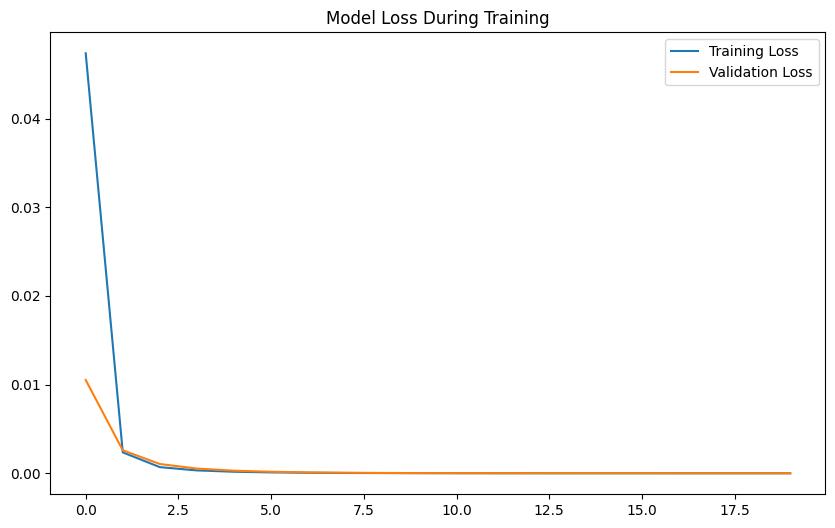

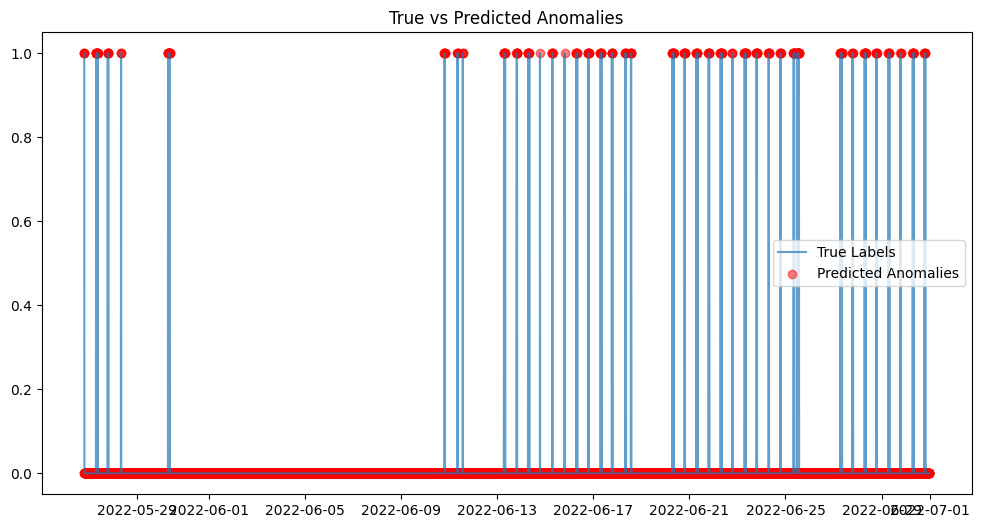

In [28]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss During Training")
plt.show()

# Plot anomalies
timestamps = df_wide['Timestamp'].values[-len(y_test):]
plt.figure(figsize=(12, 6))
plt.plot(timestamps, y_test, label='True Labels', alpha=0.7)
plt.scatter(timestamps, y_pred, color='red', label='Predicted Anomalies', alpha=0.5)
plt.legend()
plt.title("True vs Predicted Anomalies")
plt.show()
